In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn import metrics

#from sklearn.metrics import plot_roc_curve
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
df = pd.read_csv('preprocessed_ham_phishing.csv')

In [57]:
df.columns

Index(['hops', 'missing_received1', 'missing_received2', 'missing_received3',
       'missing_received4', 'missing_received5', 'missing_received6',
       'missing_received7', 'missing_received8', 'missing_subject',
       'missing_date', 'missing_message-id', 'missing_from',
       'missing_return-path', 'missing_to', 'missing_content-type',
       'missing_mime-version', 'missing_x-mailer',
       'missing_content-transfer-encoding', 'missing_x-mimeole',
       'missing_x-priority', 'missing_list-id', 'missing_x-virus-scanned',
       'missing_status', 'missing_content-length', 'missing_precedence',
       'missing_delivered-to', 'missing_list-unsubscribe', 'missing_list-post',
       'missing_list-help', 'missing_x-msmail-priority',
       'missing_x-spam-status', 'missing_sender', 'missing_x-beenthere',
       'missing_list-archive', 'missing_reply-to', 'missing_x-virus-status',
       'missing_x-spam-level', 'missing_x-spam-checker-version',
       'missing_references', 'missing_i

In [44]:
df['label'].value_counts()

label
0    2544
1    2534
Name: count, dtype: int64

In [26]:
feature_list = ['domain_match_message-id_from', 'domain_match_from_return-path',
       'domain_match_message-id_return-path', 'domain_match_message-id_sender',
       'domain_match_message-id_reply-to', 'domain_match_return-path_reply-to',
       'domain_match_reply-to_to', 'domain_match_to_in-reply-to',
       'domain_match_sender_from', 'domain_match_references_reply-to',
       'domain_match_references_in-reply-to', 'domain_match_references_to',
       'domain_match_from_reply-to', 'domain_match_to_from',
       'domain_match_to_message-id', 'label']

df = df[feature_list]

In [45]:
df.head(10)

,hops,missing_received1,missing_received2,missing_received3,missing_received4,missing_received5,missing_received6,missing_received7,missing_received8,missing_subject,...,domain_match_reply-to_to,domain_match_to_in-reply-to,domain_match_sender_from,domain_match_references_reply-to,domain_match_references_in-reply-to,domain_match_references_to,domain_match_from_reply-to,domain_match_to_from,domain_match_to_message-id,label
0,0,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
9,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [58]:
df_Y = df['label']
df_X = df.drop('label', axis=1)

In [74]:
# Check for duplicates
duplicates = df_X.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

Number of duplicate rows: 0


In [70]:
# Remove duplicate rows
df_X = df_X.drop_duplicates()
df_Y = df_Y.loc[df_X.index]

In [71]:
df_Y.value_counts()

label
1    996
0     46
Name: count, dtype: int64

In [60]:
features_list = df_X.columns
print(features_list)

Index(['hops', 'missing_received1', 'missing_received2', 'missing_received3',
       'missing_received4', 'missing_received5', 'missing_received6',
       'missing_received7', 'missing_received8', 'missing_subject',
       'missing_date', 'missing_message-id', 'missing_from',
       'missing_return-path', 'missing_to', 'missing_content-type',
       'missing_mime-version', 'missing_x-mailer',
       'missing_content-transfer-encoding', 'missing_x-mimeole',
       'missing_x-priority', 'missing_list-id', 'missing_x-virus-scanned',
       'missing_status', 'missing_content-length', 'missing_precedence',
       'missing_delivered-to', 'missing_list-unsubscribe', 'missing_list-post',
       'missing_list-help', 'missing_x-msmail-priority',
       'missing_x-spam-status', 'missing_sender', 'missing_x-beenthere',
       'missing_list-archive', 'missing_reply-to', 'missing_x-virus-status',
       'missing_x-spam-level', 'missing_x-spam-checker-version',
       'missing_references', 'missing_i

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(df_X)
df_X = scaler.transform(df_X)
df_X = pd.DataFrame(df_X, columns=features_list)
#X_test = scaler.transform(X_test)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.20, random_state=42)

In [52]:
X_train.shape

(4062, 85)

In [53]:
X_test.shape

(1016, 85)

In [63]:
# Function to evaluate model
def evaluate_model(grid, X_train, y_train, X_test, y_test, model_name):
    # Find the best hyperparameters (using 10 fold CV with the hold out fold being the validation set)
    grid.fit(X_train, y_train)

    # Check the hyperparameter results
    rf_df = pd.DataFrame(grid.cv_results_)
    print(grid.best_params_, '\n')
    print(grid.best_estimator_)

    # Get the best performing model
    best_model = grid.best_estimator_

    plot_learning_curve(best_model, 'Learning Curve for {}'.format(model_name), X_train, y_train, cv=10, n_jobs=-1)
    plt.show()

    # Train the best model on the full training data
    best_model.fit(X_train, y_train)

    # Test the best performing model on the test set
    predictions = best_model.predict(X_test)


    # Get the evaluation metrics
    print('Accuracy:', accuracy_score(y_test, predictions)*100)
    print('F1 Score:', f1_score(y_test, predictions)*100)
    print('Recall:', recall_score(y_test, predictions)*100)
    print('Precision:', precision_score(y_test, predictions)*100)
    print('ROC AUC:', roc_auc_score(y_test, predictions)*100)
    print('Confusion Matrix:', confusion_matrix(y_test, predictions))

    return best_model

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Hyperparameter tuning and testing

### Random Forest:

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[CV 6/10; 1/48] START rf__criterion=entropy, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100
[CV 2/10; 1/48] START rf__criterion=entropy, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100
[CV 1/10; 1/48] START rf__criterion=entropy, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100
[CV 3/10; 1/48] START rf__criterion=entropy, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100
[CV 8/10; 1/48] START rf__criterion=entropy, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100
[CV 4/10; 1/48] START rf__criterion=entropy, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100
[CV 7/10; 1/48] START rf__criterion=entropy, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100
[CV 5/10; 1/48] START rf__criterio

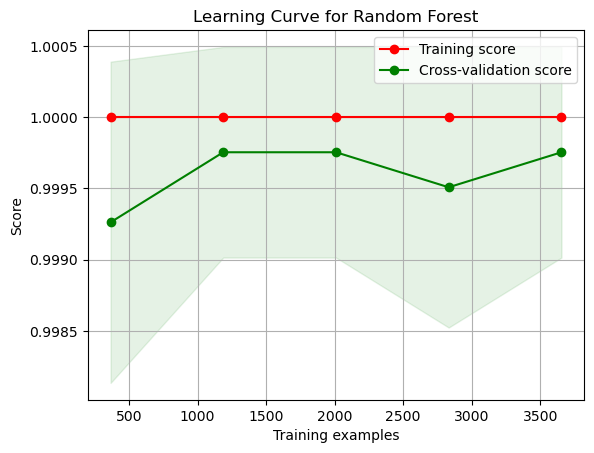

Accuracy: 99.80314960629921
F1 Score: 99.80119284294234
Recall: 100.0
Precision: 99.60317460317461
ROC AUC: 99.80544747081711
Confusion Matrix: [[512   2]
 [  0 502]]


In [64]:
pipe = Pipeline([("scale", StandardScaler()),
                ("rf", RandomForestClassifier())
                ])

param_grid_list = {'rf__n_estimators': [100, 150],
                  'rf__criterion': ['entropy', 'gini'],
                  'rf__min_samples_split': [2, 3],
                  'rf__min_samples_leaf': [1, 2],
                  'rf__max_features': [None, 'sqrt', 'log2']}

grid = GridSearchCV(pipe, param_grid=param_grid_list, cv=10, n_jobs=-1, verbose=10)

# Evaluate the model
best_model = evaluate_model(grid, X_train, y_train, X_test, y_test, 'Random Forest')

In [65]:
importances = best_model.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

Feature ranking:
1. feature 44 (0.24368013063944477)
2. feature 23 (0.14863563154511708)
3. feature 27 (0.14654091197178673)
4. feature 69 (0.07841245687525929)
5. feature 35 (0.05573320089151484)
6. feature 21 (0.047511335650025674)
7. feature 82 (0.04343202306253351)
8. feature 31 (0.03608103812804434)
9. feature 17 (0.03168707696521069)
10. feature 60 (0.030794631280962905)
11. feature 25 (0.024966044464468453)
12. feature 68 (0.012107423665644197)
13. feature 75 (0.010865815423427384)
14. feature 3 (0.00845201940176141)
15. feature 2 (0.007030142014459456)
16. feature 0 (0.006739267493245324)
17. feature 83 (0.006521408062982674)
18. feature 78 (0.0061355359727818855)
19. feature 72 (0.005416615704803493)
20. feature 20 (0.0053042902798185985)
21. feature 32 (0.004880331399065708)
22. feature 4 (0.004469755036734553)
23. feature 70 (0.004340503098859386)
24. feature 73 (0.003894257171858521)
25. feature 71 (0.003596029445928308)
26. feature 18 (0.003581197308651145)
27. feature 30 

In [83]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42)
, X_train, y_train, cv=10, scoring='accuracy')
print(f'Cross-validated accuracy: {cross_val_scores.mean()*100:.2f}%')

Cross-validated accuracy: 93.55%


### Decision Tree:

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10; 1/24] START dt__criterion=entropy, dt__max_features=None, dt__min_samples_leaf=1, dt__min_samples_split=2
[CV 2/10; 1/24] START dt__criterion=entropy, dt__max_features=None, dt__min_samples_leaf=1, dt__min_samples_split=2
[CV 1/10; 1/24] END dt__criterion=entropy, dt__max_features=None, dt__min_samples_leaf=1, dt__min_samples_split=2;, score=0.943 total time=   0.1s
[CV 3/10; 1/24] START dt__criterion=entropy, dt__max_features=None, dt__min_samples_leaf=1, dt__min_samples_split=2
[CV 2/10; 1/24] END dt__criterion=entropy, dt__max_features=None, dt__min_samples_leaf=1, dt__min_samples_split=2;, score=0.934 total time=   0.0s
[CV 4/10; 1/24] START dt__criterion=entropy, dt__max_features=None, dt__min_samples_leaf=1, dt__min_samples_split=2
[CV 5/10; 1/24] START dt__criterion=entropy, dt__max_features=None, dt__min_samples_leaf=1, dt__min_samples_split=2
[CV 3/10; 1/24] END dt__criterion=entropy, dt__max_features=Non

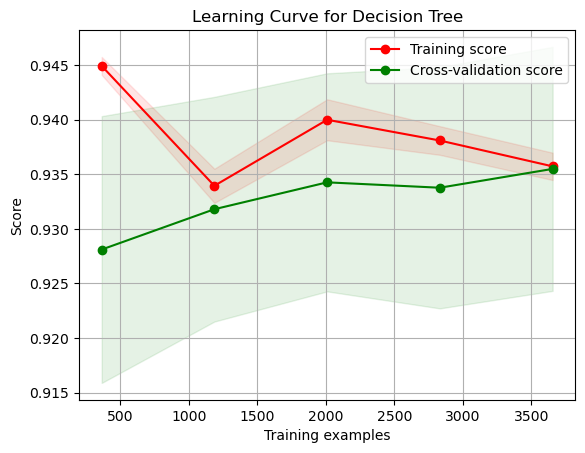

Accuracy: 92.32283464566929
F1 Score: 91.77215189873418
Recall: 86.65338645418326
Precision: 97.53363228699553
ROC AUC: 92.2566543165858
Confusion Matrix: [[503  11]
 [ 67 435]]


In [22]:
# Decision Tree Pipeline
pipe_dt = Pipeline([("scale", StandardScaler()),
                    ("dt", DecisionTreeClassifier())
                    ])

param_grid_dt = {'dt__criterion': ['entropy', 'gini'],
                 'dt__min_samples_split': [2, 3],
                 'dt__min_samples_leaf': [1, 2],
                 'dt__max_features': [None, 'sqrt', 'log2']}

grid_dt = GridSearchCV(pipe_dt, param_grid=param_grid_dt, cv=10, n_jobs=-1, verbose=10)

# Evaluate the Decision Tree model
best_model = evaluate_model(grid_dt, X_train, y_train, X_test, y_test, 'Decision Tree')

### Support Vector Machine:

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV 1/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 2/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 3/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 4/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 5/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 6/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 7/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 8/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 1/10; 1/72] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear;, score=0.943 total time=   0.1s
[CV 9/10; 1/72] START svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=linear
[CV 3/10; 1/72] END svm__C=0.1, svm__degree=3,

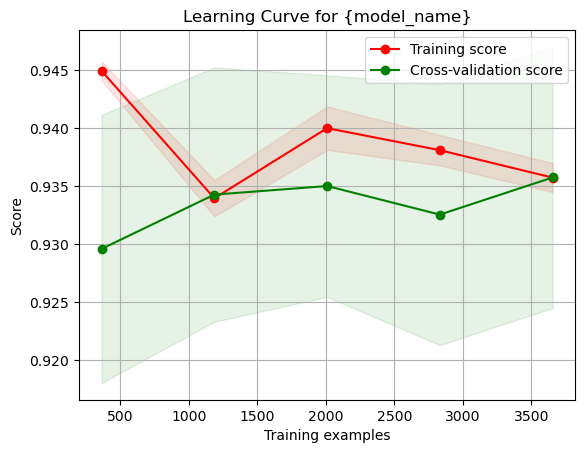

Accuracy: 92.2244094488189
F1 Score: 91.65786694825766
Recall: 86.45418326693228
Precision: 97.52808988764045
ROC AUC: 92.15705272296032
Confusion Matrix: [[503  11]
 [ 68 434]]


In [97]:
# Define the pipeline
pipe_svm = Pipeline([
    ("scale", StandardScaler()),
    ("svm", SVC())
])

# Define the hyperparameters for SVM
param_grid_list_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [3, 4, 5]  # Only relevant for 'poly' kernel
}

# Initialize GridSearchCV
grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid_list_svm, cv=10, n_jobs=-1, verbose=10)

# Evaluate the model
best_model = evaluate_model(grid_svm, X_train, y_train, X_test, y_test, 'SVM')

### RNN

In [84]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(layers.Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(X_train.shape[1], 1)))
    model.add(layers.SimpleRNN(
        hp.Int('rnn_units', min_value=32, max_value=128, step=32),
        return_sequences=False))
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Total number of trials to run
    executions_per_trial=1,  # Number of models to build for each trial
    directory='my_dir',
    project_name='rnn_tuning')

# Start the tuning process
tuner.search(X_train, y_train, epochs=10, validation_split=0.1, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# Get predictions
predictions = (best_model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
f1 = f1_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'ROC AUC: {roc_auc*100:.2f}%')
print('Confusion Matrix:')
print(conf_matrix)

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best Hyperparameters:')
print(best_hyperparameters.values)

Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.9287469387054443

Best val_accuracy So Far: 0.9287469387054443
Total elapsed time: 00h 01m 09s


/Users/eduardo/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/eduardo/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9114 - loss: 0.2330 
Test Accuracy: 92.13%
F1 Score: 91.54%
Recall: 86.25%
Precision: 97.52%
ROC AUC: 92.06%
Confusion Matrix:
[[503  11]
 [ 69 433]]
Best Hyperparameters:
{'filters': 16, 'kernel_size': 5, 'rnn_units': 128, 'dense_units': 96, 'learning_rate': 0.00021818909618719082}
